**GETTING DATASET FROM KAGGLE**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c sf-crime

Saving kaggle.json to kaggle.json
100% 40.9M/40.9M [00:03<00:00, 22.6MB/s]
100% 40.9M/40.9M [00:03<00:00, 14.2MB/s]


**UNZIPPING THE DATASET**

In [ ]:
!unzip sf-crime.zip

Archive:  sf-crime.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


**INSTALLING MODULES**

In [ ]:
!pip -q install pytorch_tabnet
!pip -q install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.1 MB/s eta 0:00:00


**IMPORTING MODULES**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import folium

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import preprocessing
import xgboost as xgb
from sklearn import model_selection
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport



import warnings
warnings.filterwarnings('ignore')

**READING THE DATASET**

In [ ]:
train_df = pd.read_csv("train.csv")
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


**DESCRIBING COLUMNS**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


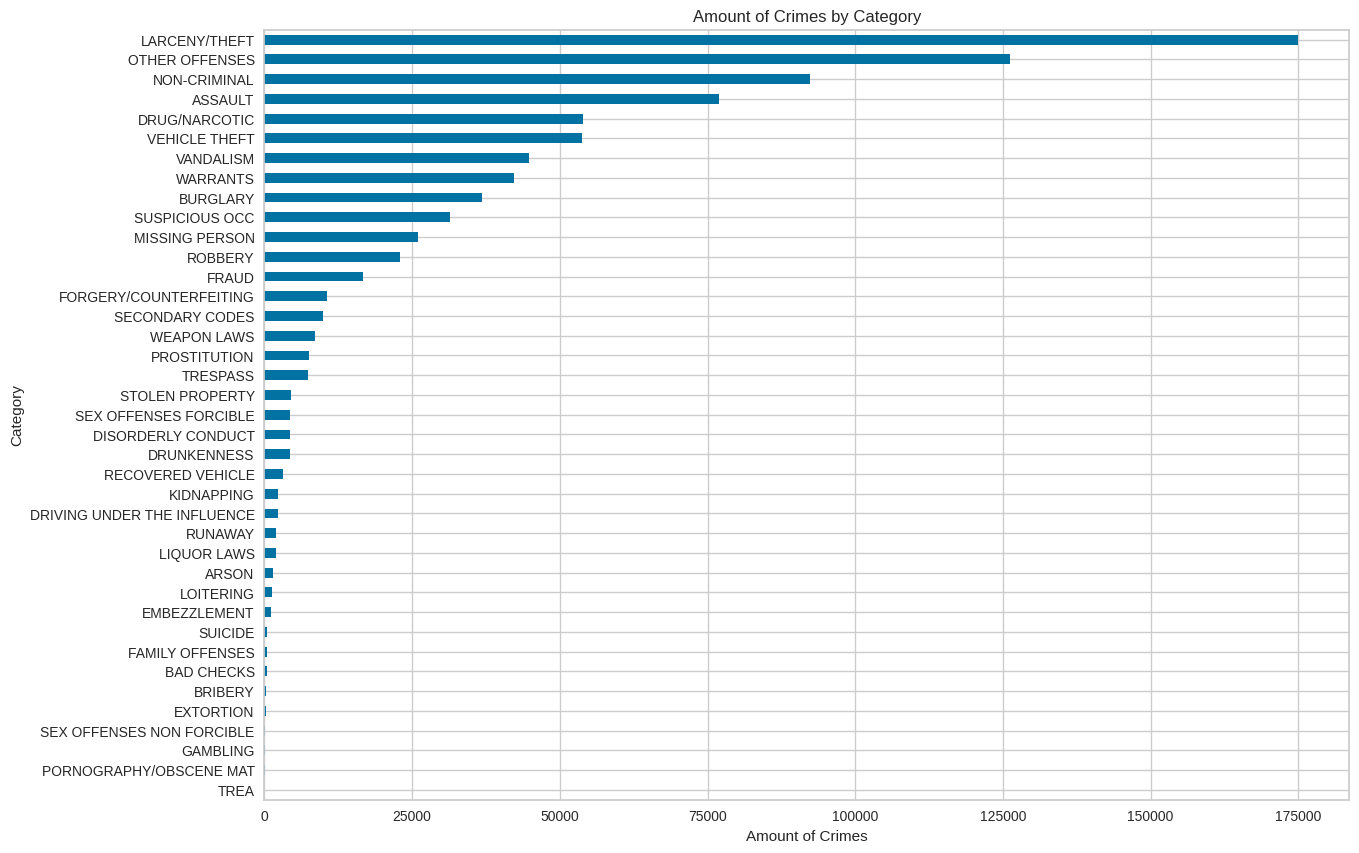

In [ ]:

# Plot Bar Chart for visualizing Category
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Category')
plt.ylabel('Crime Category')
plt.xlabel('Amount of Crimes')

train_df.groupby([train_df['Category']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()


**VISUALIZING HOTSPOTS**

In [ ]:
train_df['PdDistrict'].value_counts()
df_crime = train_df['PdDistrict'].value_counts().reset_index(drop=True)
df_crime.columns = ['Neighbourhood', 'Count']
df_crime

0    157182
1    119908
2    105296
3     89431
4     85460
5     81809
6     78845
7     65596
8     49313
9     45209
Name: PdDistrict, dtype: int64

In [ ]:
gjson = r'https://cocl.us/sanfran_geojson'
latitude = 37.77
longitude = -122.42
Sanfran_map = folium.Map(location=[latitude, longitude],tiles = "cartodbdark_matter", zoom_start=12)
Sanfran_map.choropleth(
    geo_data=gjson,
    data=df_crime,
    columns=['Neighbourhood', 'Count'],
    key_on='feature.properties.DISTRICT',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime Rate In San Francisco')
Sanfran_map

**PREPROCESSING COLUMNS**

In [ ]:
train_df['Descript'] = train_df['Descript'].map(lambda x: x.lower())
train_df['DayOfWeek'] = train_df['DayOfWeek'].map(lambda x: x.lower())
train_df['PdDistrict'] = train_df['PdDistrict'].map(lambda x: x.lower())
train_df['Resolution'] = train_df['Resolution'].map(lambda x: x.lower())
train_df['Address'] = train_df['Address'].map(lambda x: x.lower())

In [ ]:
train_df['Dates'] = pd.to_datetime(train_df['Dates'])

train_df['month'] = train_df['Dates'].dt.month
train_df['day_of_month'] = train_df['Dates'].dt.day
train_df['day_of_week'] = train_df['Dates'].dt.day_of_week
train_df['hour'] = train_df['Dates'].dt.hour

train_df = train_df.drop(['Dates', 'DayOfWeek'], axis = 1)
train_df.head(3)

,Category,Descript,PdDistrict,Resolution,Address,X,Y,month,day_of_month,day_of_week,hour
0,WARRANTS,warrant arrest,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,5,13,2,23
1,OTHER OFFENSES,traffic violation arrest,northern,"arrest, booked",oak st / laguna st,-122.425892,37.774599,5,13,2,23
2,OTHER OFFENSES,traffic violation arrest,northern,"arrest, booked",vanness av / greenwich st,-122.424363,37.800414,5,13,2,23


**Dropping columns Descript,Resolution**

In [ ]:
train_df = train_df.drop(['Descript','Resolution'],axis=1)

In [ ]:
Classes = train_df['Category'].unique()
Classes

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

**LABEL ENCODING DATASET**

In [ ]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

train_df['Category'] = label_encoder.fit_transform(train_df['Category'])
train_df['PdDistrict'] = label_encoder.fit_transform(train_df['PdDistrict'])
train_df['Address'] = label_encoder.fit_transform(train_df['Address'])



**COORELATION PLOT**

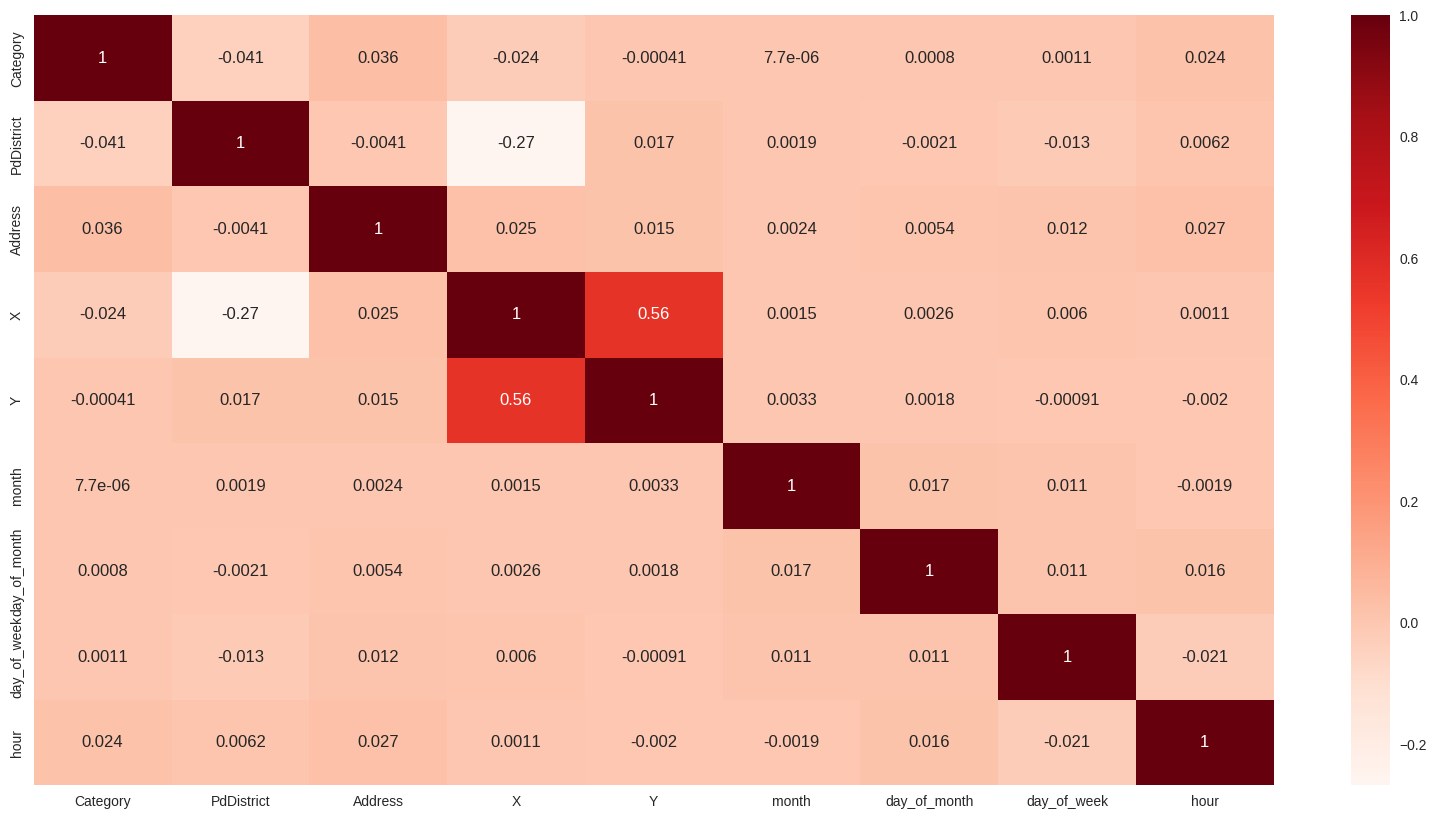

In [ ]:
plt.figure(figsize=(20,10))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**SAMPLING DATASET**

In [ ]:
train_df = train_df.sample(n=200000,random_state=42).reset_index(drop=True)

In [ ]:
X = train_df.drop('Category',axis=1)
Y = train_df['Category']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, Y,test_size = 0.2, random_state= 0)

In [ ]:
 from sklearn.preprocessing import StandardScaler

 sc= StandardScaler()
 X_train = sc.fit_transform(X_train)
 X_test = sc.transform(X_test)

In [ ]:
del X,Y

In [ ]:
del train_df

**RANDOM FOREST**

========== Random Forest Results ==========
Accuracy    :  0.2764
Recall      :  0.2764
Precision   :  0.2156541760738327
F1 Score    :  0.2764
Confusion Matrix: 
[[  0  13   0 ...   4   0   0]
 [  0 554   0 ...  98   1   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0 175   0 ... 156   0   0]
 [  0 141   0 ...  20   2   0]
 [  0  75   0 ...   6   0   0]]
================= Classification Report =================

                             precision    recall  f1-score   support

                   WARRANTS       0.00      0.00      0.00        71
             OTHER OFFENSES       0.19      0.16      0.17      3501
              LARCENY/THEFT       0.00      0.00      0.00        11
              VEHICLE THEFT       0.00      0.00      0.00        13
                  VANDALISM       0.24      0.02      0.04      1671
               NON-CRIMINAL       0.33      0.01      0.02       194
                    ROBBERY       0.00      0.00      0.00       104
                    ASSAULT      

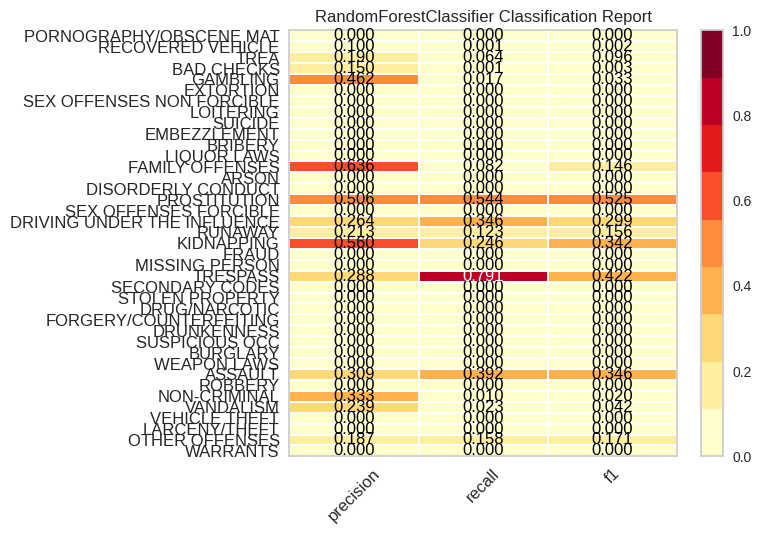

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True,
                                  max_depth = 150,
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=X_train,
             y=y_train)

# Prediction
result = rf_model.predict(X_test)

y_pred_prob_rf = rf_model.predict_proba(X_test)
df_rf_prob = pd.DataFrame(y_pred_prob_rf,columns=Classes)

ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()

In [ ]:
df_rf_prob.head()

,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,BURGLARY,...,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0.001719,0.084234,0.000231,0.000855,0.078411,0.002875,0.003150,0.030254,0.005331,0.001406,...,0.0,0.003606,0.000000,0.036046,0.0,0.005850,0.055615,0.128572,0.023887,0.007004
1,0.005909,0.057632,0.000000,0.000000,0.004485,0.001078,0.005735,0.034494,0.010768,0.000000,...,0.0,0.001597,0.000122,0.023352,0.0,0.004009,0.060815,0.116112,0.043799,0.008227
2,0.000096,0.046709,0.001076,0.000000,0.112328,0.001083,0.000417,0.012457,0.000911,0.000707,...,0.0,0.015374,0.000225,0.043253,0.0,0.007757,0.038999,0.054637,0.011501,0.003915
3,0.000077,0.107894,0.000000,0.000000,0.011287,0.006442,0.000373,0.212340,0.007514,0.000072,...,0.0,0.015785,0.000000,0.045385,0.0,0.020966,0.017911,0.009622,0.107325,0.025405
4,0.000000,0.142918,0.000000,0.000000,0.014222,0.003561,0.000167,0.243215,0.002695,0.000000,...,0.0,0.001704,0.000425,0.039185,0.0,0.011320,0.021048,0.005015,0.084220,0.009803


**CAT BOOST**

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Early stop iteration :  199
========== CATBOOST Results ==========
Accuracy    :  0.240475
Recall      :  0.240475
Precision   :  0.12523578753070597
F1 Score    :  0.240475
Confusion Matrix: 
[[  0  12   0 ...   0   0   0]
 [  0 331   0 ...   6   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0 168   0 ...   9   0   0]
 [  0  72   0 ...   2   0   0]
 [  0  52   0 ...   0   0   0]]
================= Classification Report =================

                             precision    recall  f1-score   support

                   WARRANTS       0.00      0.00      0.00        71
             OTHER OFFENSES       0.16      0.09      0.12      3501
              LARCENY/THEFT       0.00      0.00      0.00        11
              VEHICLE THEFT       0.00      0.00      0.00        13
                  VANDALISM       0.00      0.00      0.00      1671
               NON-CRIMINAL       0.00      0.00      0.00       194
                    ROBBERY       0.00      0.00      0.00       104
   

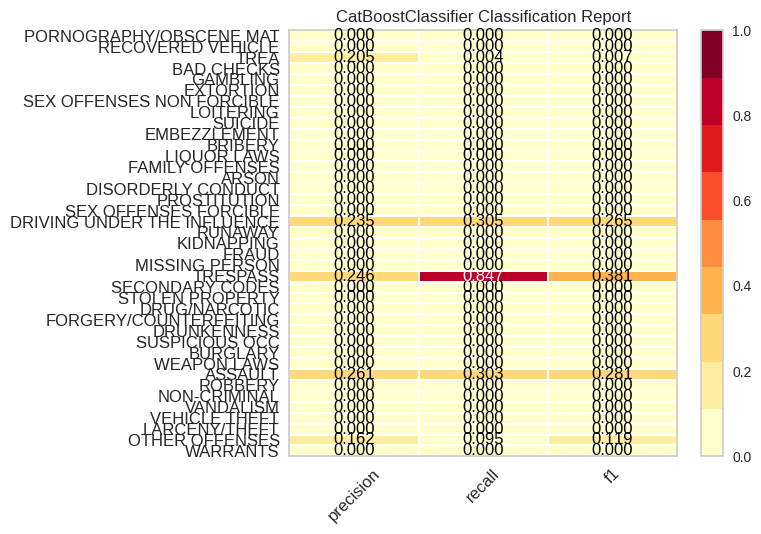

In [ ]:
from yellowbrick.contrib.wrapper import wrap
clf = CatBoostClassifier(iterations=200,max_depth=6,random_seed=42,learning_rate=0.01,custom_loss=['AUC', 'Accuracy'])

clf.fit(X_train, y_train,eval_set=(X_test, y_test),verbose=False,plot=True)
early_stop = clf.get_best_iteration()
print("Early stop iteration : ",early_stop)

result = clf.predict(X_test)
df_clf_prob = pd.DataFrame(clf.predict_proba(X_test),columns=Classes)


ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== CATBOOST Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes

clf_wrap = wrap(clf)
visualizer = ClassificationReport(clf_wrap, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()


In [ ]:
df_clf_prob.head()

,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,BURGLARY,...,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0.004743,0.089714,0.003987,0.004024,0.049382,0.006714,0.005609,0.037673,0.007865,0.004546,...,0.003816,0.007996,0.004092,0.036666,0.003625,0.009457,0.062003,0.091263,0.033726,0.011799
1,0.004883,0.050683,0.003944,0.004017,0.008805,0.005631,0.008457,0.040158,0.008092,0.004155,...,0.003888,0.006770,0.004008,0.025865,0.003784,0.005784,0.046383,0.088157,0.037194,0.012324
2,0.005148,0.063672,0.004235,0.003741,0.099030,0.007080,0.004516,0.021512,0.005966,0.004953,...,0.003748,0.009556,0.004344,0.045013,0.003598,0.012961,0.043506,0.054883,0.025080,0.009231
3,0.004062,0.094523,0.003806,0.003748,0.019624,0.008622,0.004457,0.237349,0.007301,0.004288,...,0.003646,0.008941,0.003959,0.032153,0.003550,0.013904,0.022831,0.014286,0.084961,0.012090
4,0.004033,0.092427,0.003762,0.003640,0.019981,0.011570,0.004437,0.232840,0.007229,0.004312,...,0.003546,0.007827,0.003863,0.034656,0.003453,0.017113,0.021437,0.014303,0.083440,0.011508


**XGBOOST**

[18:54:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

========== XGB Results ==========
Accuracy    :  0.265
Recall      :  0.265
Precision   :  0.2096454260965313
F1 Score    :  0.265
Confusion Matrix: 
[[  0  13   0 ...   6   0   0]
 [  0 473   0 ... 111   1   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0 193   0 ... 157   0   0]
 [  0 115   0 ...  25   4   0]
 [  0  58   0 ...   9   1   0]]
================= Classification Report =================

                             precision    recall  f1-score   support

                   WARRANTS       0.00      0.00      0.00        71
             OTHER OFFENSES       0.17      0.14      0.15      3501
              LARCENY/THEFT       0.00      0.00      0.00        11
              VEHICLE THEFT       0.00      0.00      0.00        13
                  VANDALISM       0.26      0.01      0.02      1671
               NON-CRIMINAL       0.28      0.05      0.09       194
                    ROBBERY    

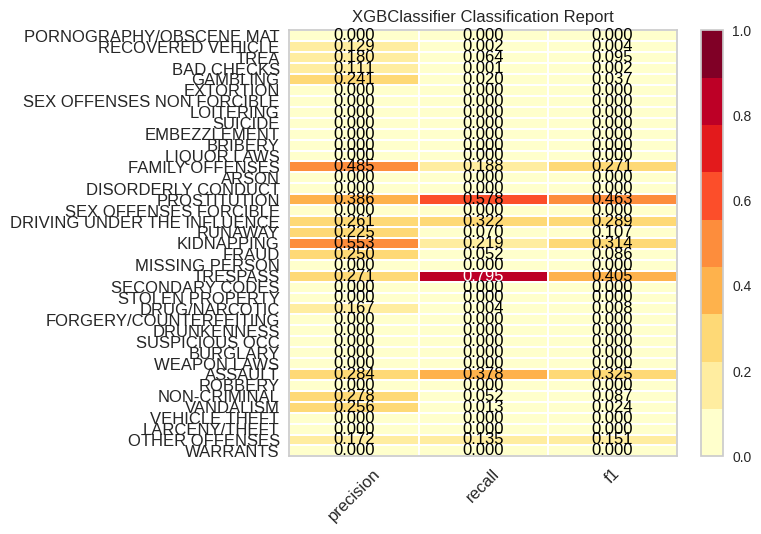

In [ ]:
xgb = XGBClassifier(booster =  'gbtree',
                        n_jobs = 4,
                        objective = 'multi:softmax',
                        silent = 0,
                        subsample = 1,
                        learning_rate = 0.01,
                        max_depth = 6,
                        min_child_weight = 2,
                        colsample_bytree = 1,
                        n_estimators= 200,
                        reg_lambda= 1)

xgb.fit(X_train, y_train)

result = xgb.predict(X_test)
df_xgb_prob = pd.DataFrame(xgb.predict_proba(X_test),columns=Classes)



ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== XGB Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(xgb, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()

In [ ]:
df_xgb_prob.head()


,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,BURGLARY,...,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0.009697,0.072322,0.009394,0.009567,0.053279,0.011929,0.010981,0.028785,0.012206,0.010329,...,0.009373,0.011425,0.009542,0.033612,0.009269,0.012959,0.050118,0.084875,0.021418,0.013984
1,0.009591,0.047255,0.009202,0.009462,0.009490,0.009903,0.009520,0.028586,0.011932,0.009233,...,0.009270,0.010196,0.009371,0.029870,0.009168,0.009949,0.038032,0.061216,0.024387,0.013690
2,0.009194,0.053390,0.009880,0.008958,0.086619,0.010323,0.008967,0.016135,0.010069,0.009793,...,0.008886,0.011922,0.009046,0.043020,0.008788,0.016499,0.033741,0.039193,0.020121,0.012751
3,0.009545,0.078247,0.009246,0.009299,0.023475,0.010214,0.009771,0.183410,0.011771,0.010166,...,0.009226,0.019660,0.009392,0.031703,0.009123,0.012790,0.018391,0.014884,0.077419,0.019147
4,0.009082,0.068269,0.008953,0.008849,0.023330,0.012875,0.008858,0.191892,0.010927,0.009674,...,0.008779,0.011344,0.008937,0.033543,0.008681,0.015661,0.019454,0.013815,0.072179,0.014964


**TABNET**

In [ ]:
from yellowbrick.contrib.wrapper import wrap
trch = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=0.001),
        scheduler_params={
            "step_size":10, # how to use learning rate scheduler
            "gamma":0.9
        },
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax', # "sparsemax",
        verbose=25 # print every 25 epochs
    )

    # fit the model
trch.fit(
        X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=25, patience=20,
        batch_size=128,
        num_workers=4,
        weights=1,
        drop_last=False
    )


result = trch.predict(X_test)
df_torch_prob = pd.DataFrame(trch.predict_proba(X_test),columns=Classes)


ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== TABNET Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)


epoch 0  | loss: 3.57721 | train_accuracy: 0.01162 | valid_accuracy: 0.0118  |  0:00:47s

Early stopping occurred at epoch 24 with best_epoch = 4 and best_valid_accuracy = 0.02718
========== TABNET Results ==========
Accuracy    :  0.027175
Recall      :  0.027175
Precision   :  0.07890832076434433
F1 Score    :  0.027174999999999998
Confusion Matrix: 
[[ 10   0   5 ...   0   0   0]
 [121   3 260 ...  64   0  19]
 [  0   0   0 ...   0   0   0]
 ...
 [ 83   2 139 ... 103   0  15]
 [ 49   1 135 ...  24   0  11]
 [ 12   1  25 ...   9   0   3]]


In [ ]:
df_torch_prob.head()

,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,BURGLARY,...,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0.018871,0.029852,0.009573,0.124737,0.025478,0.016176,0.016885,0.027279,0.022889,0.007697,...,0.024893,0.025291,0.030701,0.023149,1.302565e-04,0.016262,0.033058,0.036390,0.024485,0.039605
1,0.027745,0.023107,0.016018,0.004824,0.011300,0.031590,0.026445,0.041903,0.029131,0.030432,...,0.009672,0.034616,0.019508,0.037994,9.988863e-10,0.023904,0.031175,0.030907,0.044476,0.037619
2,0.034664,0.029140,0.039566,0.014416,0.033463,0.024774,0.025644,0.019215,0.025858,0.034884,...,0.015594,0.025463,0.019595,0.028314,2.633772e-03,0.028045,0.028261,0.027378,0.022688,0.025922
3,0.019635,0.033200,0.005952,0.023062,0.016323,0.035931,0.023971,0.074796,0.031503,0.016509,...,0.003667,0.041230,0.012601,0.034915,5.557771e-06,0.034370,0.031509,0.021900,0.054221,0.035789
4,0.022729,0.027031,0.046225,0.035160,0.030388,0.022100,0.014569,0.034278,0.021908,0.037377,...,0.010716,0.028578,0.042495,0.030776,2.425929e-04,0.035881,0.026475,0.021614,0.030807,0.026075


**CNN XGB**

Epoch 1/20
5000/5000 [==============================] - 21s 4ms/step - loss: 2.6927 - accuracy: 0.1990 - val_loss: 2.6110 - val_accuracy: 0.2069
Epoch 2/20
5000/5000 [==============================] - 18s 4ms/step - loss: 2.6282 - accuracy: 0.2127 - val_loss: 2.5872 - val_accuracy: 0.2207
Epoch 3/20
5000/5000 [==============================] - 19s 4ms/step - loss: 2.6060 - accuracy: 0.2202 - val_loss: 2.5715 - val_accuracy: 0.2297
Epoch 4/20
5000/5000 [==============================] - 18s 4ms/step - loss: 2.5907 - accuracy: 0.2254 - val_loss: 2.5607 - val_accuracy: 0.2310
Epoch 5/20
5000/5000 [==============================] - 21s 4ms/step - loss: 2.5772 - accuracy: 0.2288 - val_loss: 2.5576 - val_accuracy: 0.2338
Epoch 6/20
5000/5000 [==============================] - 18s 4ms/step - loss: 2.5696 - accuracy: 0.2306 - val_loss: 2.5488 - val_accuracy: 0.2333
Epoch 7/20
5000/5000 [==============================] - 20s 4ms/step - loss: 2.5632 - accuracy: 0.2316 - val_loss: 2.5386 - val_ac

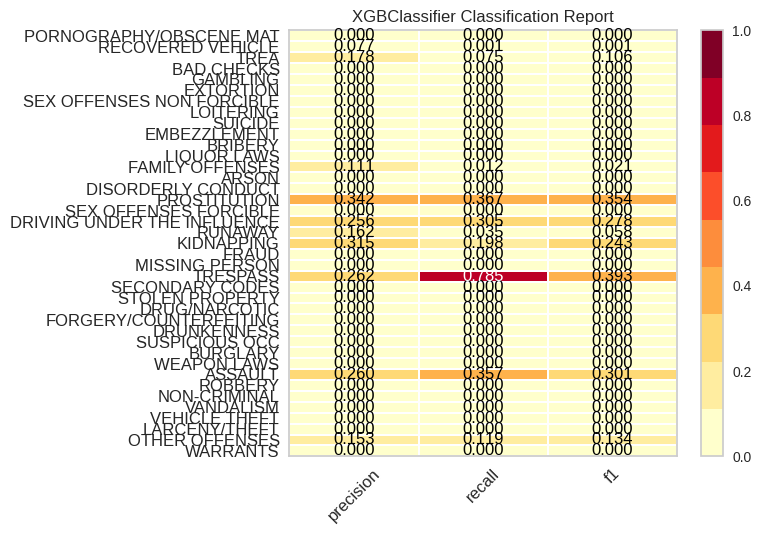

In [ ]:

# Reshape data for 1D CNN
X_train_scaled_re = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_scaled_re = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create 1D CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(Classes), activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train 1D CNN model
model.fit(X_train_scaled_re, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled_re, y_test))

# Extract feature layer from 1D CNN model
feature_layer_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
X_train_features = feature_layer_model.predict(X_train_scaled_re)
X_test_features = feature_layer_model.predict(X_test_scaled_re)

# Create XGBoostClassifier
xgb_clf = XGBClassifier(booster =  'gbtree',
                        n_jobs = 4,
                        objective = 'multi:softmax',
                        silent = 0,
                        subsample = 1,
                        learning_rate = 0.01,
                        max_depth = 6,
                        min_child_weight = 2,
                        colsample_bytree = 1,
                        n_estimators= 300,
                        reg_lambda= 1)

# Fit XGBoostClassifier using 1D CNN features
xgb_clf.fit(X_train_features, y_train)

# Evaluate XGBoostClassifier on test data
accuracy = xgb_clf.score(X_test_features, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

result = xgb_clf.predict(X_test_features)
df_xgb_cnn_prob = pd.DataFrame(xgb_clf.predict_proba(X_test_features),columns=Classes)


ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== cnn xgb Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(xgb_clf, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test_features,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()



In [ ]:
df_xgb_cnn_prob.head()

,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,BURGLARY,...,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0.006348,0.092589,0.005650,0.005729,0.052594,0.008797,0.006143,0.041276,0.010982,0.006670,...,0.005609,0.009222,0.005930,0.036513,0.005484,0.011294,0.067373,0.071118,0.033832,0.014542
1,0.005671,0.039228,0.005456,0.005596,0.005792,0.007277,0.007870,0.048543,0.009447,0.005408,...,0.005479,0.008110,0.005424,0.027297,0.005357,0.006510,0.040030,0.063706,0.040608,0.027543
2,0.007480,0.066203,0.006400,0.005830,0.092146,0.007567,0.006136,0.013898,0.006262,0.007402,...,0.005708,0.009835,0.006158,0.049840,0.005581,0.012247,0.048328,0.049769,0.021281,0.012105
3,0.005969,0.082062,0.005808,0.005890,0.019982,0.008237,0.006142,0.221702,0.010230,0.006063,...,0.005767,0.010098,0.006096,0.028789,0.005638,0.012312,0.020965,0.010505,0.083878,0.015400
4,0.005703,0.100819,0.005549,0.005628,0.016427,0.007613,0.005869,0.210897,0.008411,0.005794,...,0.005510,0.007344,0.005455,0.036097,0.005387,0.010353,0.021404,0.011887,0.084494,0.014691


**Bagging Classifier**

========== Bagging Results ==========
Accuracy    :  0.264125
Recall      :  0.264125
Precision   :  0.22031261893910634
F1 Score    :  0.264125
Confusion Matrix: 
[[  0   8   0 ...   5   2   1]
 [  0 557   2 ... 124  70  18]
 [  0   0   0 ...   0   0   0]
 ...
 [  0 153   0 ... 478  25   4]
 [  1 144   0 ...  36  96  11]
 [  0  43   0 ...  10  10  16]]
================= Classification Report =================

                             precision    recall  f1-score   support

                   WARRANTS       0.00      0.00      0.00        71
             OTHER OFFENSES       0.17      0.16      0.17      3501
              LARCENY/THEFT       0.00      0.00      0.00        11
              VEHICLE THEFT       0.00      0.00      0.00        13
                  VANDALISM       0.13      0.07      0.09      1671
               NON-CRIMINAL       0.11      0.04      0.06       194
                    ROBBERY       0.04      0.01      0.02       104
                    ASSAULT     

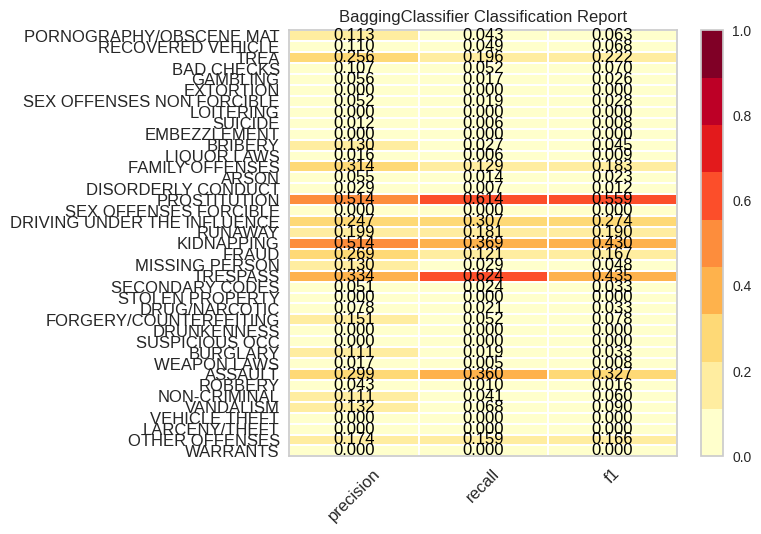

In [ ]:
bagg = BaggingClassifier(n_jobs = -1,
                         n_estimators = 50,
                         max_features = 3,
                        )

bagg.fit(X_train, y_train)


result = bagg.predict(X_test)
df_bagg_prob = pd.DataFrame(bagg.predict_proba(X_test),columns=Classes)

ac_sc = accuracy_score(y_test, result)
rc_sc = recall_score(y_test, result, average="weighted")
pr_sc = precision_score(y_test, result, average="weighted")
f1_sc = f1_score(y_test, result, average='micro')
confusion_m = confusion_matrix(y_test, result)

print("========== Bagging Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

target_names = Classes
visualizer = ClassificationReport(bagg, classes=target_names)
visualizer.fit(X=X_train, y=y_train)     # Fit the training data to the visualizer
visualizer.score(X_test,y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, result, target_names=target_names))

g = visualizer.poof()

In [ ]:
df_bagg_prob.head()

,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,BURGLARY,...,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0.000156,0.009562,0.0,0.0,0.002345,0.000301,0.000368,0.047972,0.000424,0.000000,...,0.0,0.000156,0.0,0.004266,0.0,0.000217,0.048389,0.040076,0.030281,0.000217
1,0.000000,0.023844,0.0,0.0,0.023742,0.000465,0.000000,0.031575,0.001429,0.000000,...,0.0,0.013195,0.0,0.088885,0.0,0.020476,0.023782,0.148880,0.033803,0.002348
2,0.000000,0.042488,0.0,0.0,0.182336,0.000000,0.000000,0.002589,0.000885,0.000000,...,0.0,0.011667,0.0,0.043397,0.0,0.003017,0.004125,0.140886,0.005990,0.000984
3,0.000000,0.039741,0.0,0.0,0.002556,0.004161,0.000000,0.082635,0.000187,0.000333,...,0.0,0.065796,0.0,0.141334,0.0,0.049655,0.014392,0.006263,0.074256,0.049110
4,0.000000,0.273105,0.0,0.0,0.060609,0.000000,0.000313,0.227403,0.000370,0.000000,...,0.0,0.000000,0.0,0.028397,0.0,0.005656,0.023634,0.007122,0.055834,0.001852


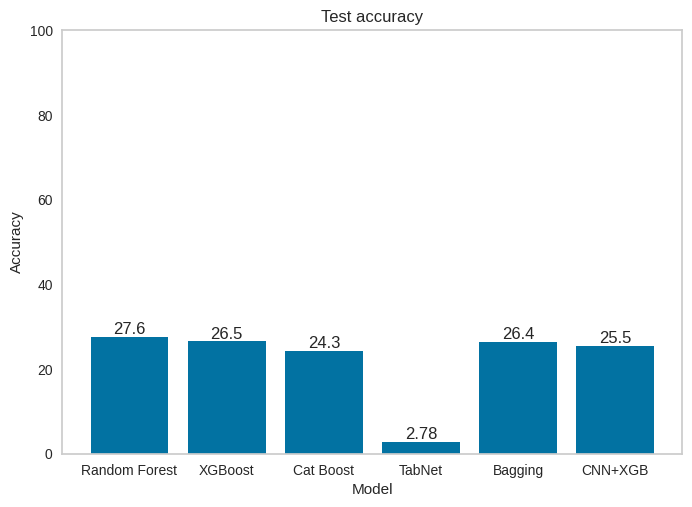

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = ['Random Forest','XGBoost','Cat Boost','TabNet', 'Bagging','CNN+XGB']
accuracy = [27.6,26.5,24.3,2.78,26.4,25.5]

fig, ax = plt.subplots()


# Create the bar chart
ax.bar(X, accuracy)

# Annotate the values
for i, v in enumerate(accuracy):
    ax.annotate(str(v), xy=(i, v), ha='center', va='bottom')

# Add title and axis labels
plt.ylim(0, 100)
plt.grid(visible=False)
ax.set_title('Test accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

plt.show()